In [1]:
import os
import time

import cv2
import matplotlib.pyplot as plt

import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda
import tensorrt as trt
from PIL import Image
import pdb
%matplotlib inline

In [2]:
class HostDeviceMem(object):
    def __init__(self, host_mem, device_mem):
        self.host = host_mem
        self.device = device_mem

    def __str__(self):
        return "Host:\n" + str(self.host) + "\nDevice:\n" + str(self.device)

    def __repr__(self):
        return self.__str__()


def load_engine(trt_runtime, engine_path):
    with open(engine_path, "rb") as f:
        engine_data = f.read()
    engine = trt_runtime.deserialize_cuda_engine(engine_data)
    return engine

# Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
def allocate_buffers(engine, batch_size=-1):
    inputs = []
    outputs = []
    bindings = []
    stream = cuda.Stream()
    for binding in engine:
        # pdb.set_trace()
        size = trt.volume(engine.get_binding_shape(binding)) * batch_size
        dtype = trt.nptype(engine.get_binding_dtype(binding))
        # Allocate host and device buffers
        host_mem = cuda.pagelocked_empty(size, dtype)
        device_mem = cuda.mem_alloc(host_mem.nbytes)
        # Append the device buffer to device bindings.
        bindings.append(int(device_mem))
        # Append to the appropriate list.
        if engine.binding_is_input(binding):
            inputs.append(HostDeviceMem(host_mem, device_mem))
            # print(f"input: shape:{engine.get_binding_shape(binding)} dtype:{engine.get_binding_dtype(binding)}")
        else:
            outputs.append(HostDeviceMem(host_mem, device_mem))
            # print(f"output: shape:{engine.get_binding_shape(binding)} dtype:{engine.get_binding_dtype(binding)}")
    return inputs, outputs, bindings, stream



def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
    # Transfer input data to the GPU.
    [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
    # Run inference.
    context.execute_async(
        batch_size=batch_size, bindings=bindings, stream_handle=stream.handle
    )
    # Transfer predictions back from the GPU.
    [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
    # Synchronize the stream
    stream.synchronize()
    # Return only the host outputs.
    return [out.host for out in outputs]

# TensorRT logger singleton
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_engine_path = "./models/tao_model.engine"
im_size = (256, 256)
model_input_shape = (1,1,256,256)

trt_runtime = trt.Runtime(TRT_LOGGER)
# pdb.set_trace()
trt_engine = load_engine(trt_runtime, trt_engine_path)
# This allocates memory for network inputs/outputs on both CPU and GPU
inputs, outputs, bindings, stream = allocate_buffers(trt_engine)
# Execution context is needed for inference
context = trt_engine.create_execution_context()
context.set_binding_shape(0, model_input_shape)

True

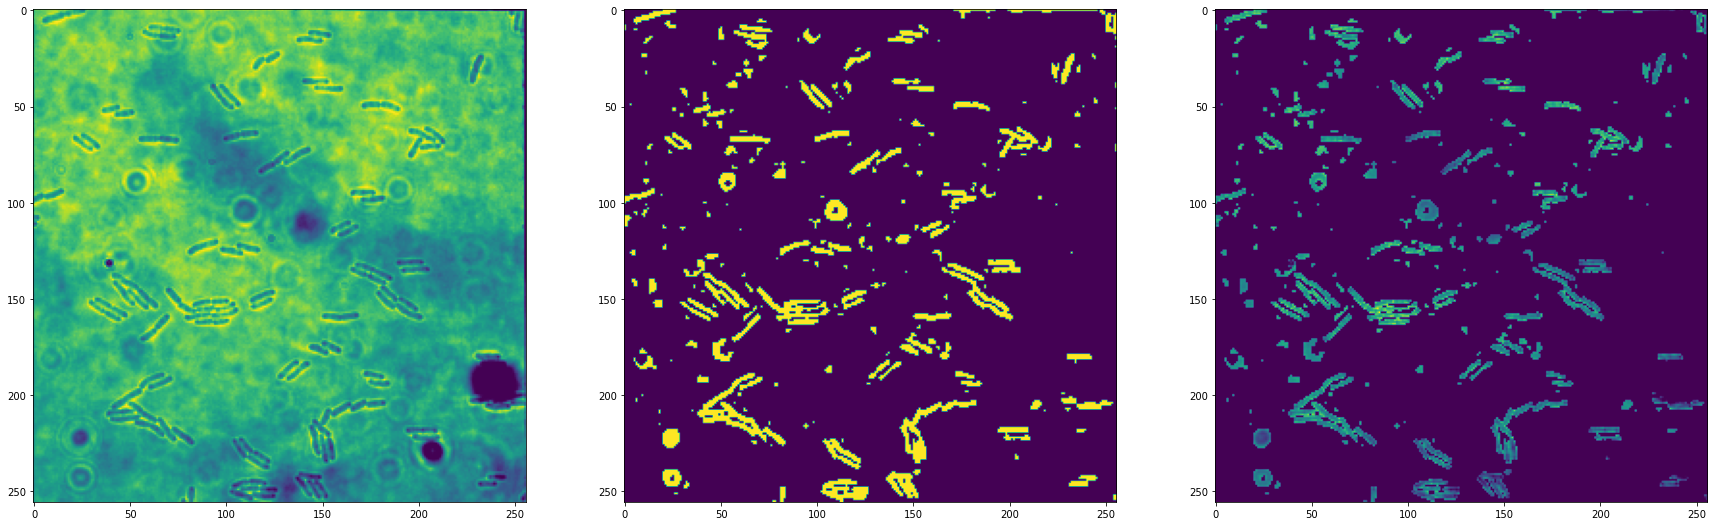

In [15]:
image = cv2.imread('data/pos7_fr_60.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, im_size) / 255
np.copyto(inputs[0].host, image.ravel())

pred_mask = do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
pred_mask = pred_mask[0].reshape(im_size)

_, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].imshow(image)
axes[1].imshow(pred_mask)
axes[2].imshow(image*pred_mask)
plt.show()

In [ ]:
image = cv2.imread('data/pos7_fr_60.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.resize(image, im_size)
np.copyto(inputs[0].host, image.ravel())

pred_mask = do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
pred_mask = pred_mask[0].reshape(im_size)

_, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].imshow(image)
axes[1].imshow(pred_mask)
axes[2].imshow(image*pred_mask)
plt.show()

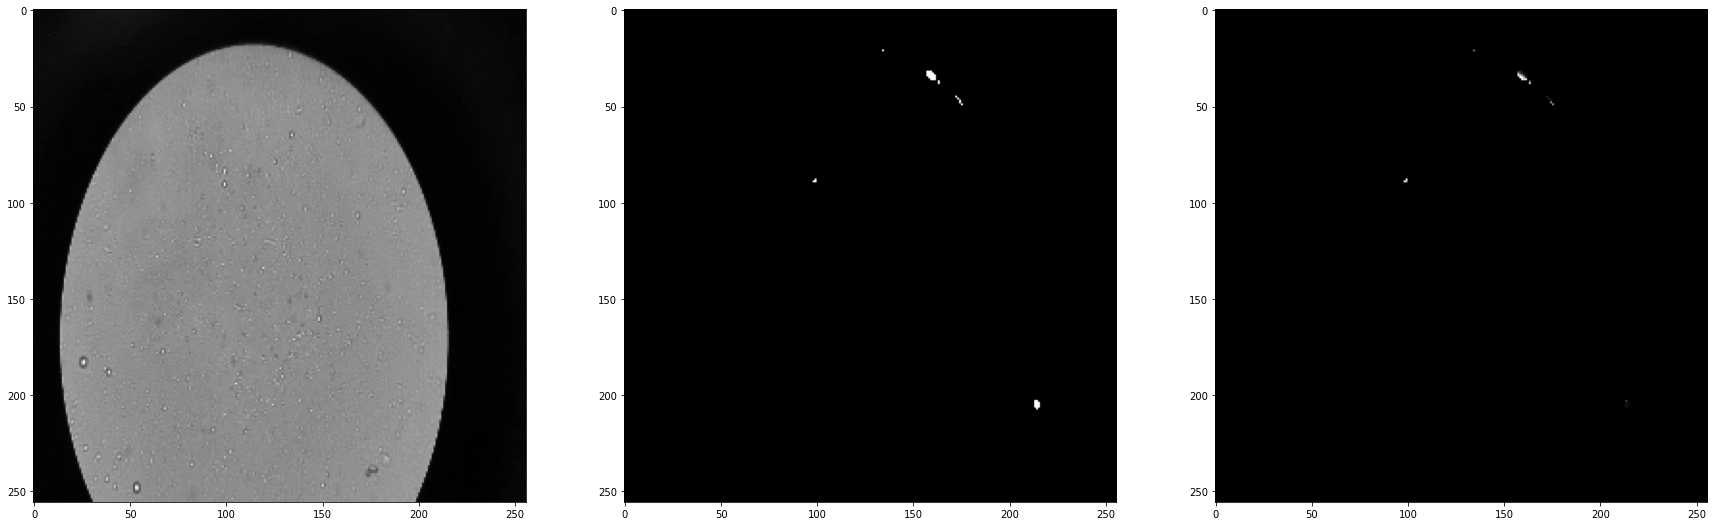

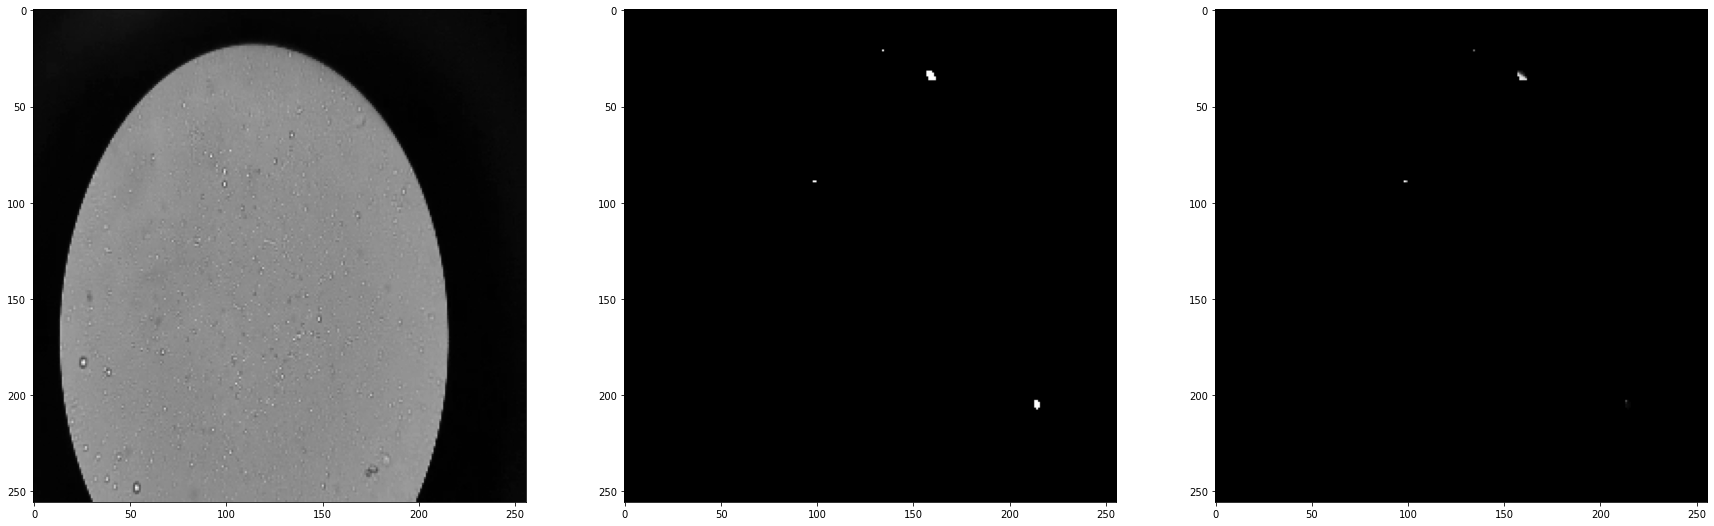

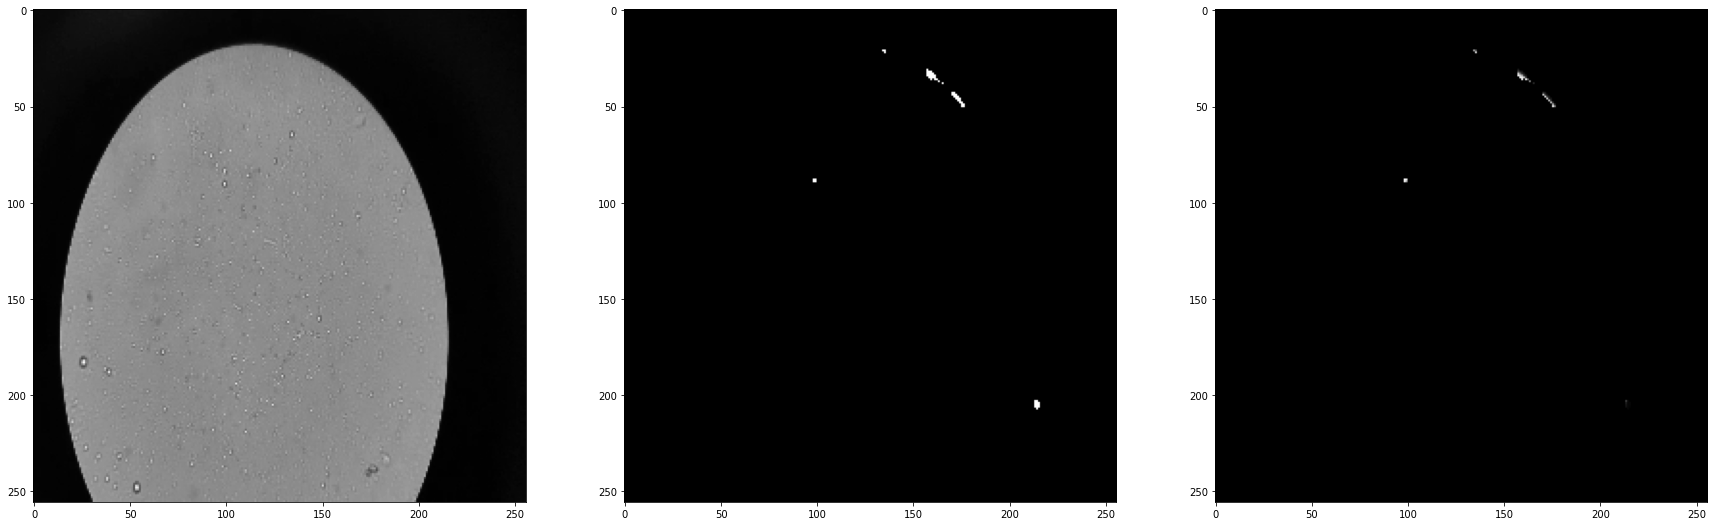

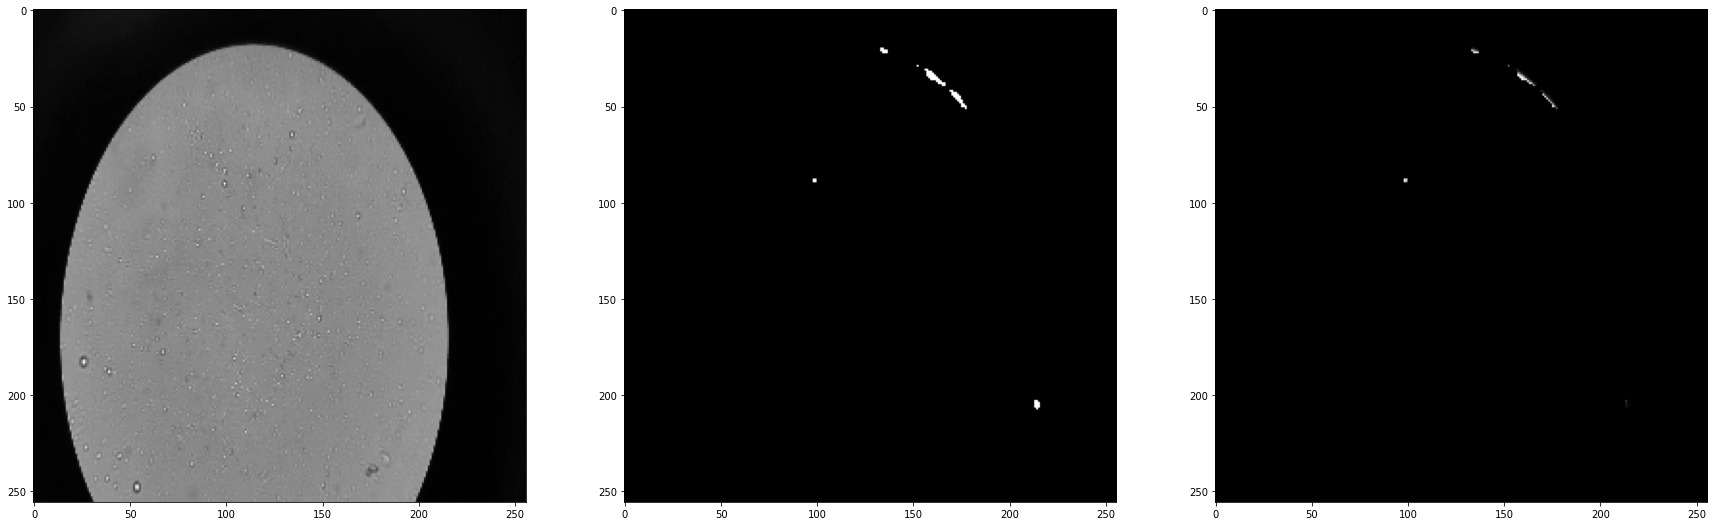

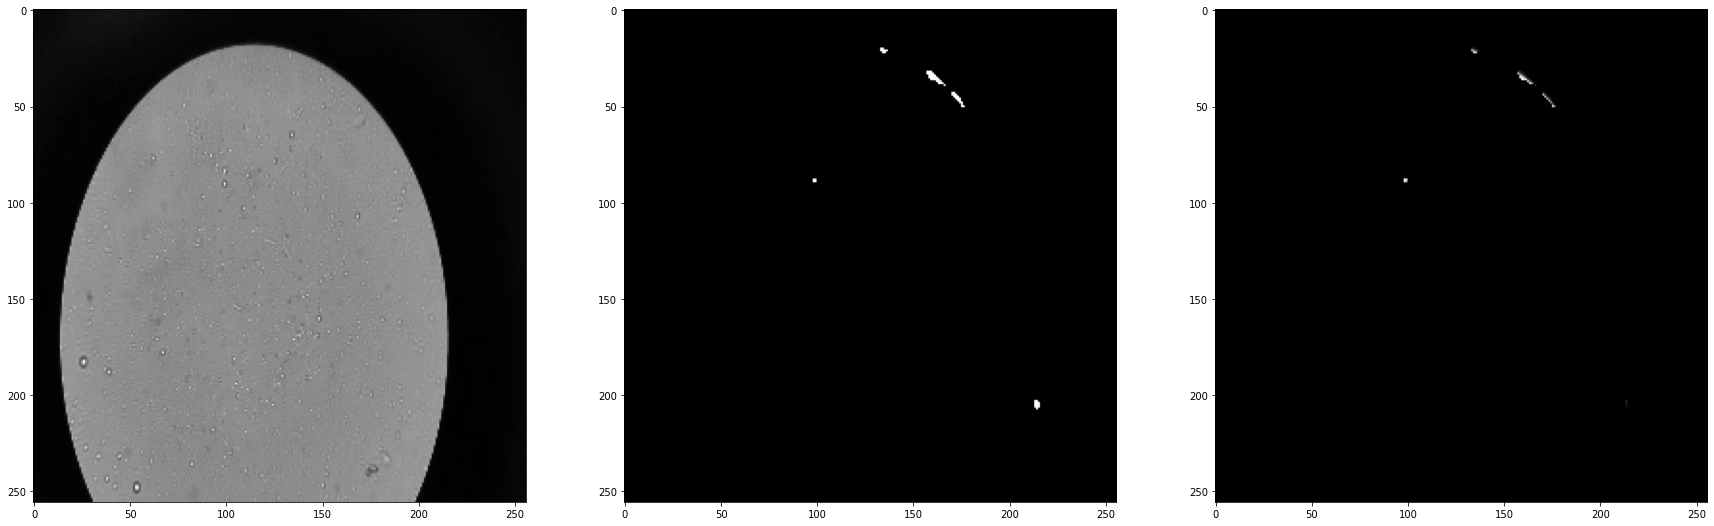

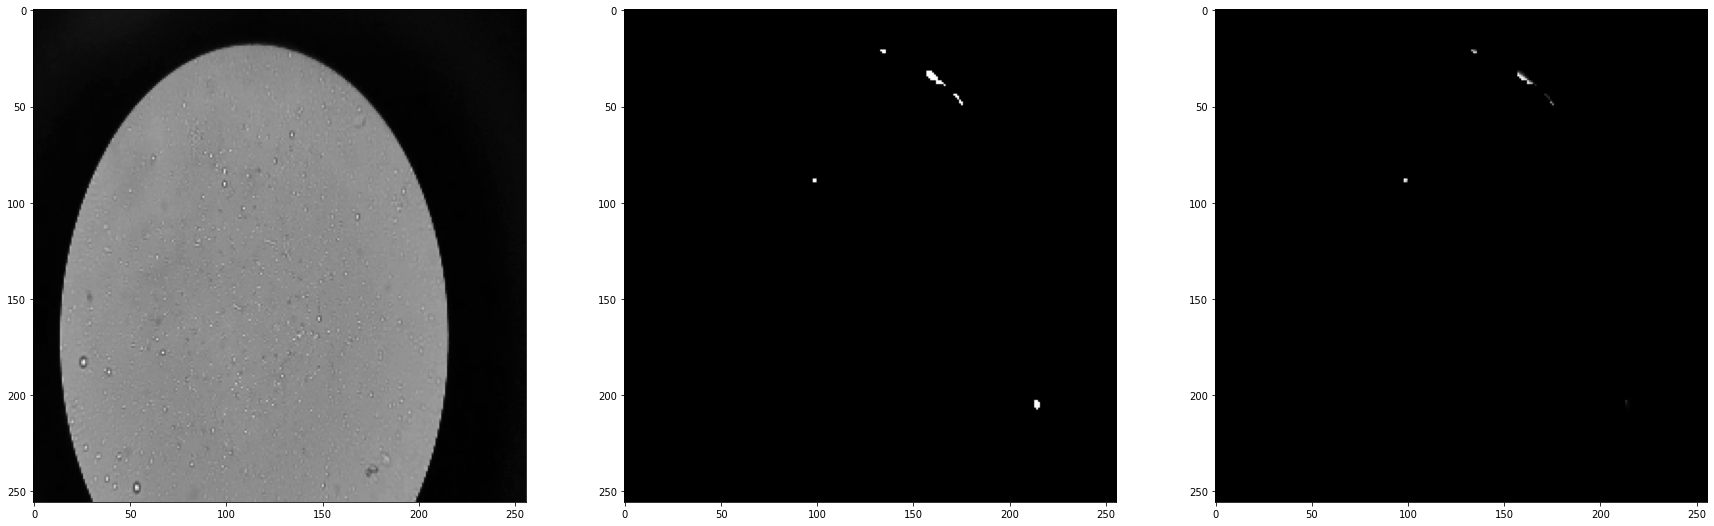

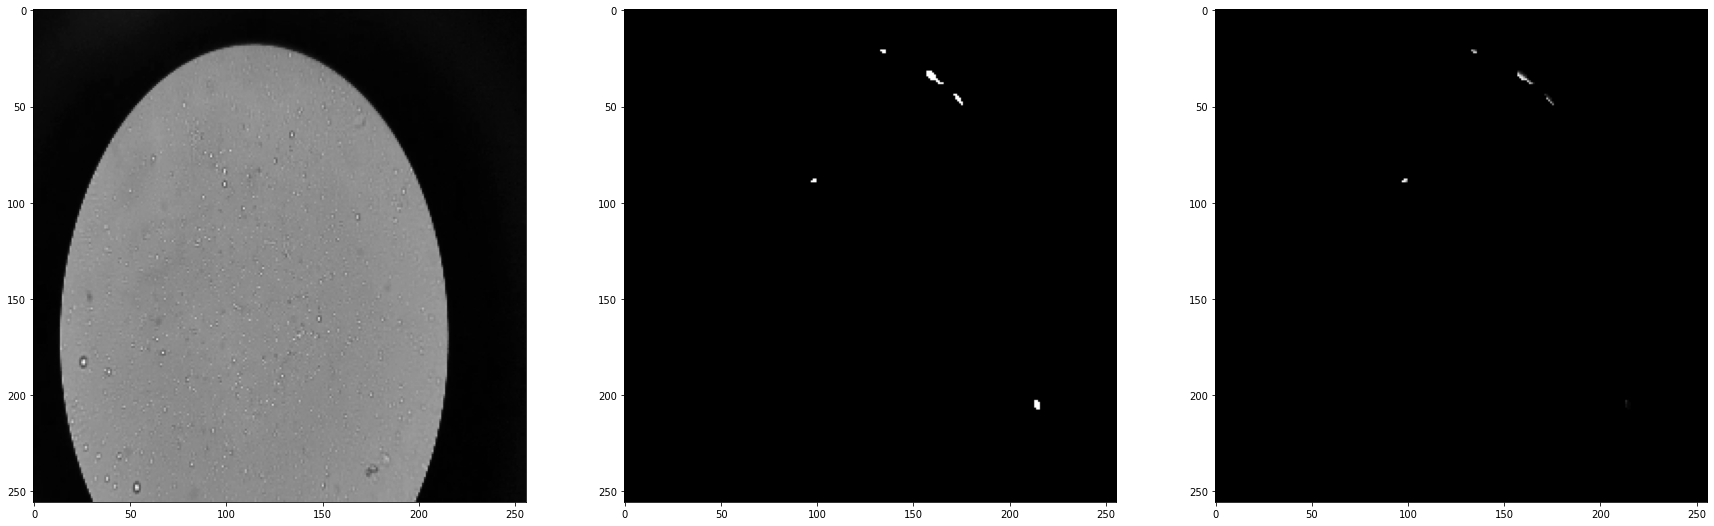

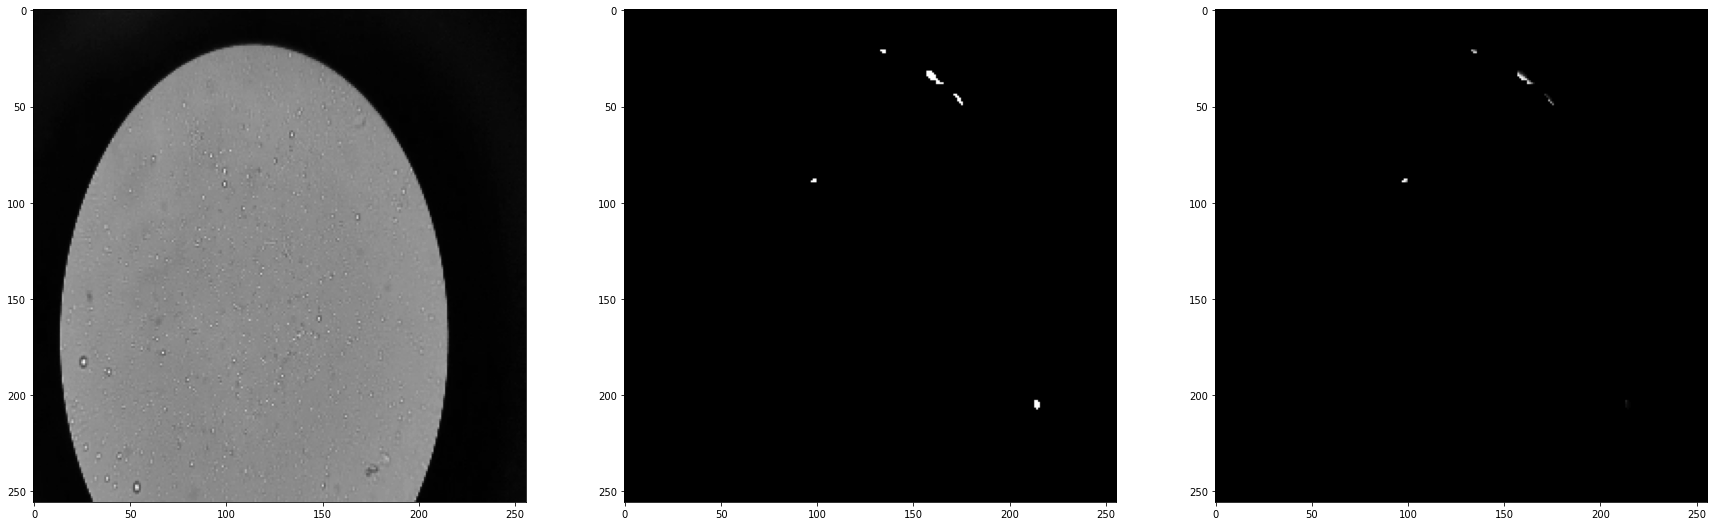

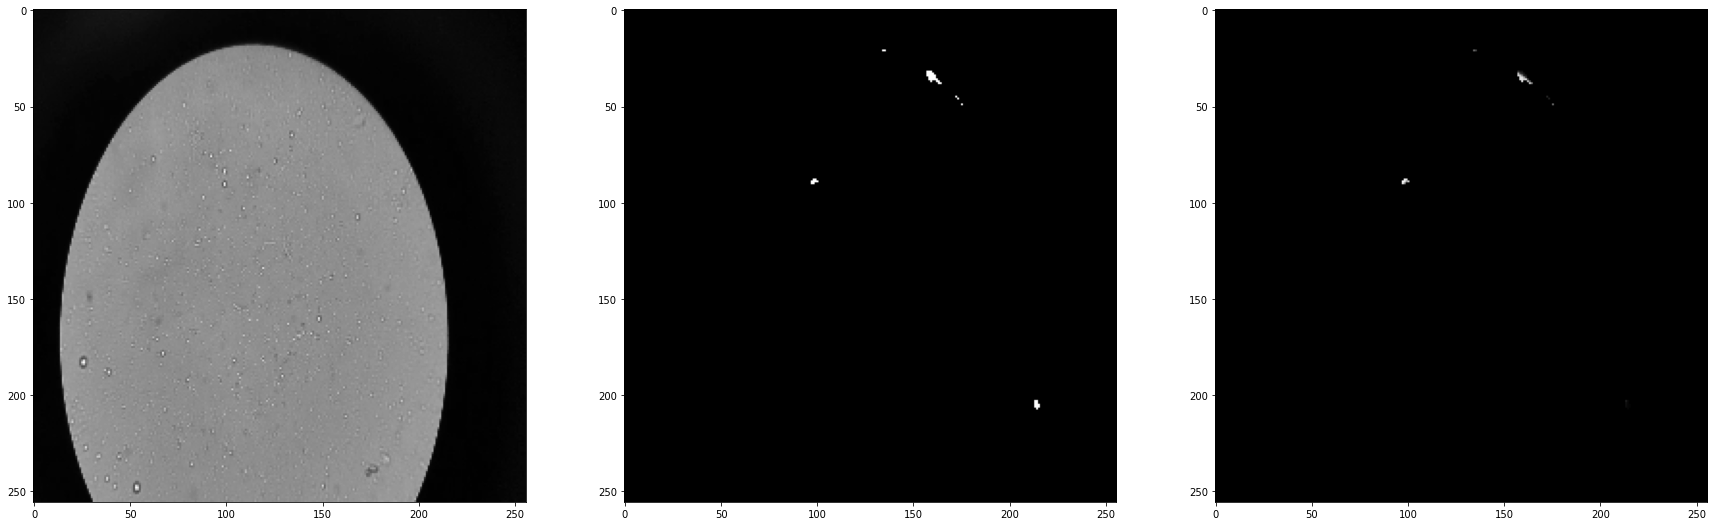

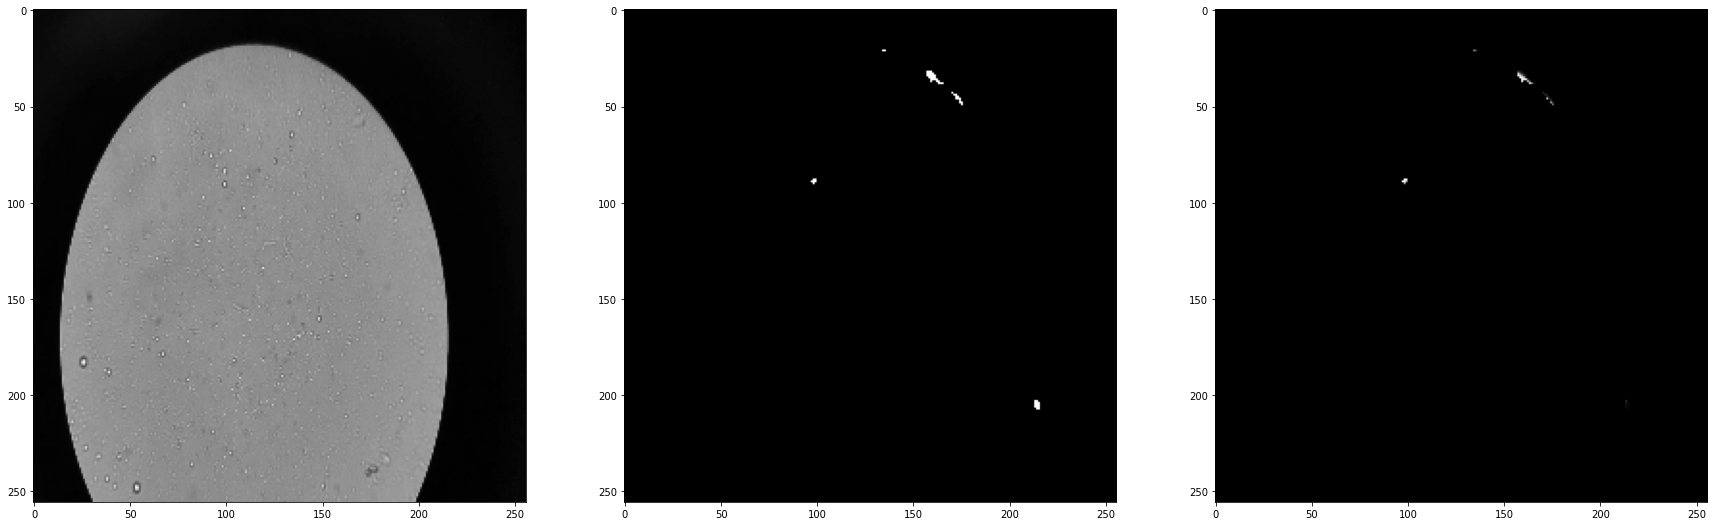

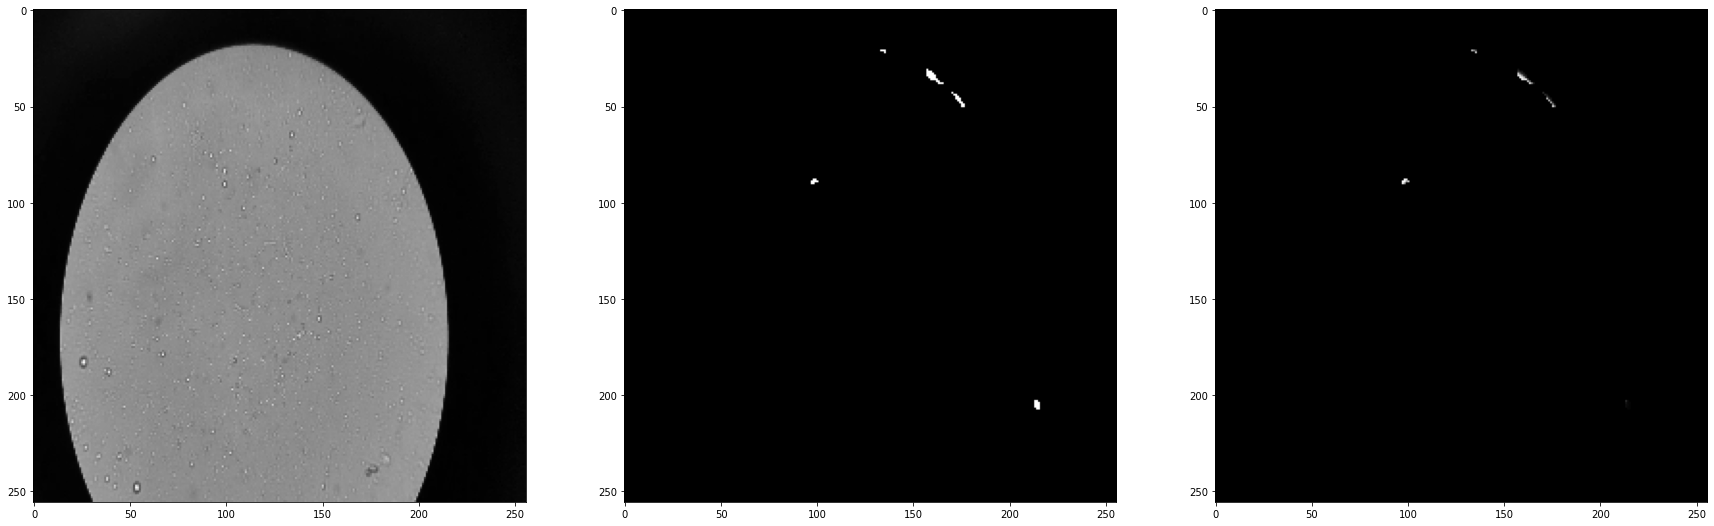

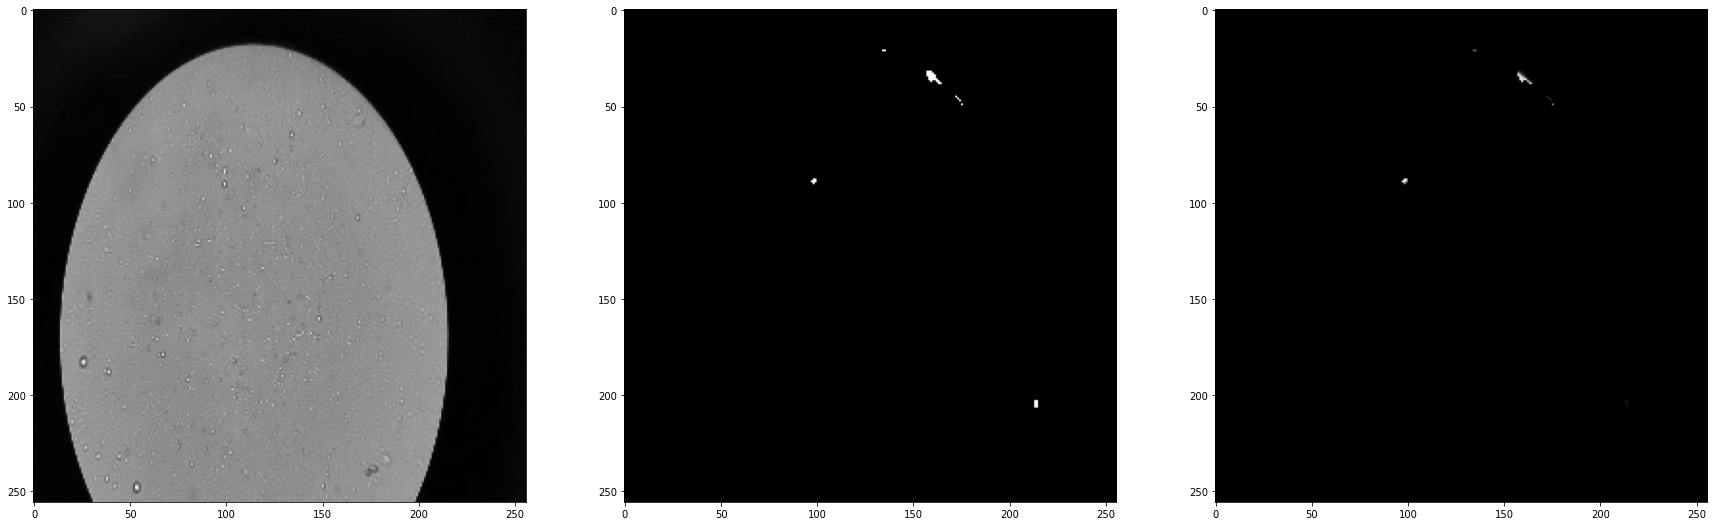

KeyboardInterrupt: 

In [14]:
# 選擇第二隻攝影機
cap = cv2.VideoCapture('./data/7_20 -7.MOV')

while(True):
    # 從攝影機擷取一張影像
    is_frame_valid, frame = cap.read()
    if is_frame_valid:   
        image = frame[10:,310:,:]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, im_size) / 255
        np.copyto(inputs[0].host, image.ravel())

        pred_mask = do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        pred_mask = pred_mask[0].reshape(im_size)
        
        _, axes = plt.subplots(1, 3, figsize=(30, 10))
        
        axes[0].imshow(image, cmap='gray')
        axes[1].imshow(pred_mask, cmap='gray')
        axes[2].imshow(image*pred_mask, cmap='gray')
        plt.show()

In [9]:
image.shape

(256, 256, 3)

In [ ]:
# class TRTInference(object):
#     """Manages TensorRT objects for model inference."""
#     def __init__(self, 
#                  trt_engine_path, 
#                  trt_engine_datatype=trt.DataType.FLOAT, 
#                  calib_dataset=None, 
#                  batch_size=-1):
#         """Initializes TensorRT objects needed for model inference.
#         Args:
#             trt_engine_path (str): path where TensorRT engine should be stored
#             uff_model_path (str): path of .uff model
#             trt_engine_datatype (trt.DataType):
#                 requested precision of TensorRT engine used for inference
#             batch_size (int): batch size for which engine
#                 should be optimized for
#         """
        
#         # Initialize runtime needed for loading TensorRT engine from file
#         self.trt_runtime = trt.Runtime(TRT_LOGGER)
#         self.batch_size = batch_size
#         # TRT engine placeholder
#         self.trt_engine = self.load_engine(trt_engine_path)

#         # This allocates memory for network inputs/outputs on both CPU and GPU
#         self.inputs, self.outputs, self.bindings, self.stream = self.allocate_buffers()

#         # Execution context is needed for inference
#         self.context = self.trt_engine.create_execution_context()
        
        

#     def load_engine(self, engine_path):
#         with open(engine_path, "rb") as f:
#             engine_data = f.read()
#         engine = self.trt_runtime.deserialize_cuda_engine(engine_data)
#         return engine
    
#     # Allocates all buffers required for an engine, i.e. host/device inputs/outputs.
#     def allocate_buffers(self):
#         inputs = []
#         outputs = []
#         bindings = []
#         stream = cuda.Stream()
#         for binding in self.trt_engine:
#             # pdb.set_trace()
#             size = trt.volume(self.trt_engine.get_binding_shape(binding)) * self.batch_size
#             dtype = trt.nptype(self.trt_engine.get_binding_dtype(binding))
#             # Allocate host and device buffers
#             host_mem = cuda.pagelocked_empty(size, dtype)
#             device_mem = cuda.mem_alloc(host_mem.nbytes)
#             # Append the device buffer to device bindings.
#             bindings.append(int(device_mem))
#             # Append to the appropriate list.
#             if self.trt_engine.binding_is_input(binding):
#                 inputs.append(HostDeviceMem(host_mem, device_mem))
#                 # print(f"input: shape:{engine.get_binding_shape(binding)} dtype:{engine.get_binding_dtype(binding)}")
#             else:
#                 outputs.append(HostDeviceMem(host_mem, device_mem))
#                 # print(f"output: shape:{engine.get_binding_shape(binding)} dtype:{engine.get_binding_dtype(binding)}")
#         return inputs, outputs, bindings, stream
    
    
#     def infer(self, image_array):
#         """Infers model on given image.
#         Args:
#             image_path (str): image to run object detection model on
#         """

#         # Copy it into appropriate place into memory
#         # (self.inputs was returned earlier by allocate_buffers())
#         np.copyto(self.inputs[0].host, image_array.ravel())

#         # When infering on single image, we measure inference
#         # time to output it to the user
#         inference_start_time = time.time()

#         # Fetch output from the model
#         detection_out = do_inference(
#             self.context, bindings=self.bindings, inputs=self.inputs,
#             outputs=self.outputs, stream=self.stream)

#         # Output inference time
#         print("TensorRT inference time: {} ms".format(
#             int(round((time.time() - inference_start_time) * 1000))))

#         # And return results
#         return detection_out
    
# def do_inference(context, bindings, inputs, outputs, stream, batch_size=1):
#     # Transfer input data to the GPU.
#     [cuda.memcpy_htod_async(inp.device, inp.host, stream) for inp in inputs]
#     # Run inference.
#     context.execute_async(
#         batch_size=batch_size, bindings=bindings, stream_handle=stream.handle
#     )
#     # Transfer predictions back from the GPU.
#     [cuda.memcpy_dtoh_async(out.host, out.device, stream) for out in outputs]
#     # Synchronize the stream
#     stream.synchronize()
#     # Return only the host outputs.
#     return [out.host for out in outputs]